In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
import copy
from sklearn.linear_model import LinearRegression

# Seoul Bike Sharing Demand
The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information
https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

## Dataset Information
Additional Information

Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes. 
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.. on..



In [2]:
cols = ['bike_count','hour','temp','humidity','wind','visibility','dew_pt_temp','radiation','rain','snow','functional'] # set a name for the columns
df=pd.read_csv('SeoulBikeData.csv', encoding='unicode_escape').drop(['Date', 'Holiday', 'Seasons'], axis = 1)
df.columns = cols
df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df[df['hour']==12]
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,12,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,12,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,12,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,12,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,12,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


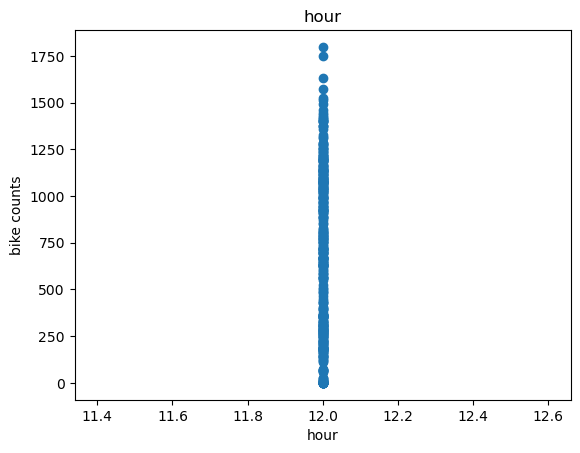

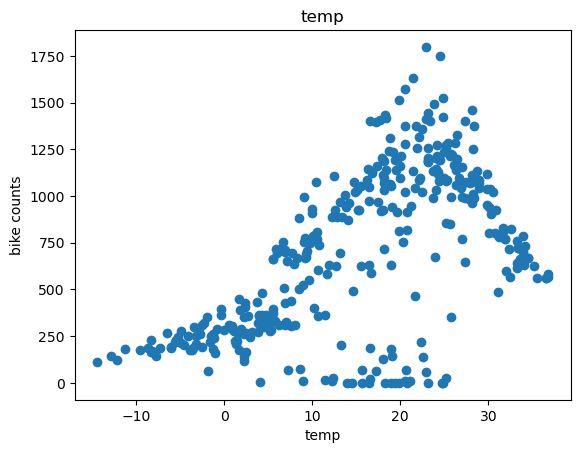

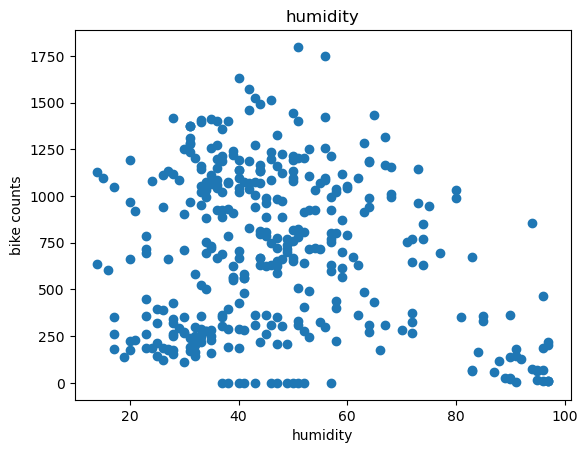

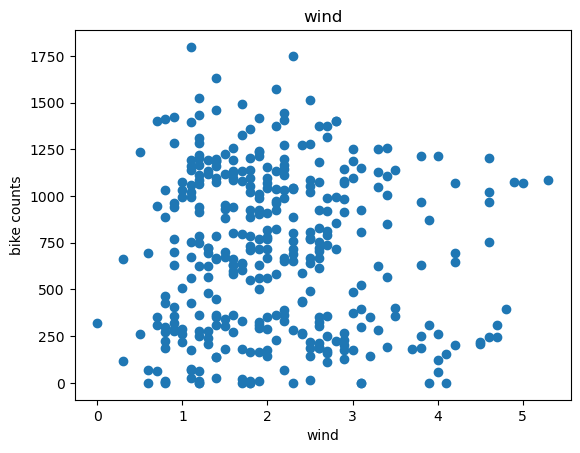

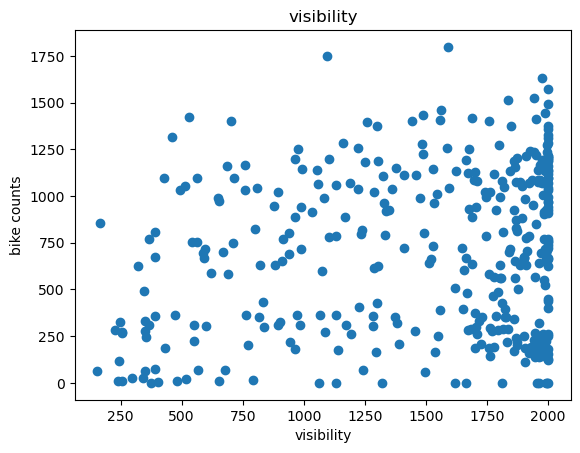

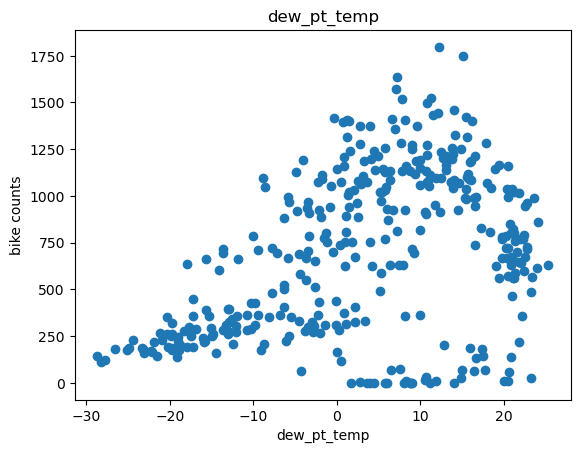

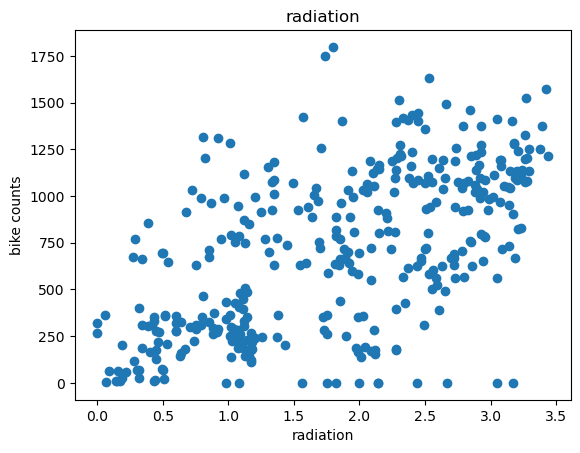

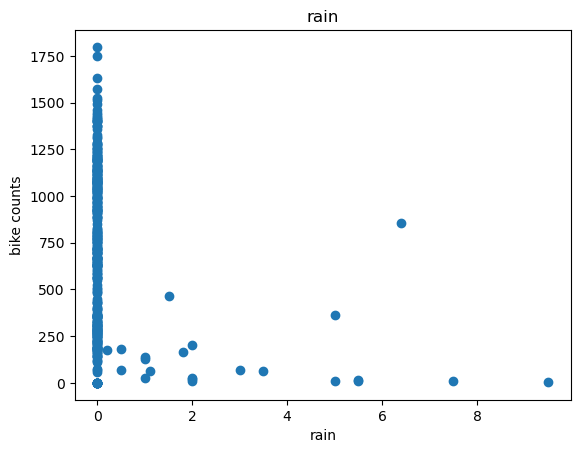

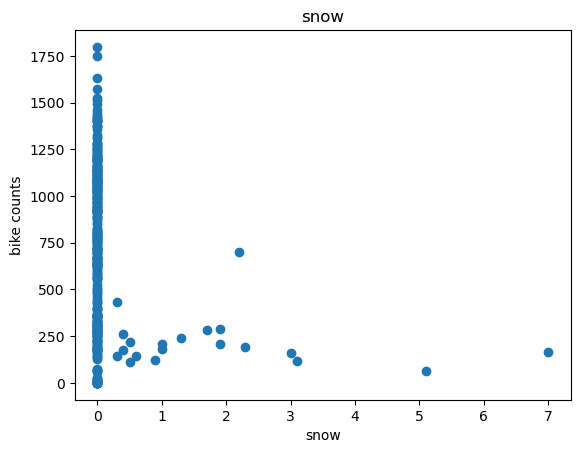

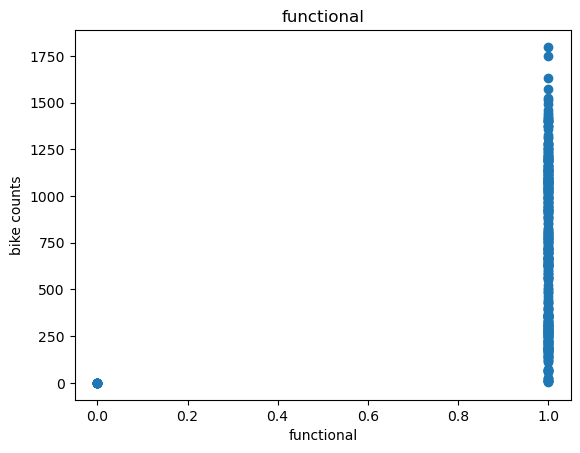

In [3]:
for label in df.columns[1:]:
    plt.scatter(df[label] , df['bike_count'])
    plt.title(label)
    plt.ylabel('bike counts')
    plt.xlabel(label)
    plt.show()

In [4]:
df = df.drop(['wind', 'visibility', 'functional'],axis = 1)

## Train / Validation / Test

In [5]:
train , valid , test = np.split(df.sample(frac = 1) , [int(0.6*len(df)), int(0.8*len(df))]) #splitting the data 

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def get_xy (dataframe, x = None , y='bike count'):
    dataframe = copy.deepcopy(dataframe)
    
    if x is None :
        x = dataframe[[c for c in dataframe.columns if c!=y]].values
    else:
        if len(x) == 1:
            x = dataframe[x[0]].values.reshape(-1,1)  
        else:
            x = dataframe[x].values
    y = dataframe[y].values.reshape(-1,1)
    data = np.hstack((x,y))
    return data , x , y 
        

In [7]:
_, x_train , y_train = get_xy(train ,x= ['temp'], y = 'bike_count')
_, x_valid , y_valid = get_xy(valid ,x= ['temp'], y = 'bike_count')
_, x_test , y_test = get_xy(test ,x= ['temp'], y = 'bike_count')

## Linear Regression Model

In [8]:
reg_model = LinearRegression()
reg_model.fit(x_train, y_train)
print(f'Coffecient = {reg_model.coef_}, Interception = {reg_model.intercept_} \n R² ={reg_model.score(x_test,y_test)} ')

Coffecient = [[20.91171252]], Interception = [371.29935303] 
 R² =0.2431635775278157 


Text(0, 0.5, 'Bikes Count')

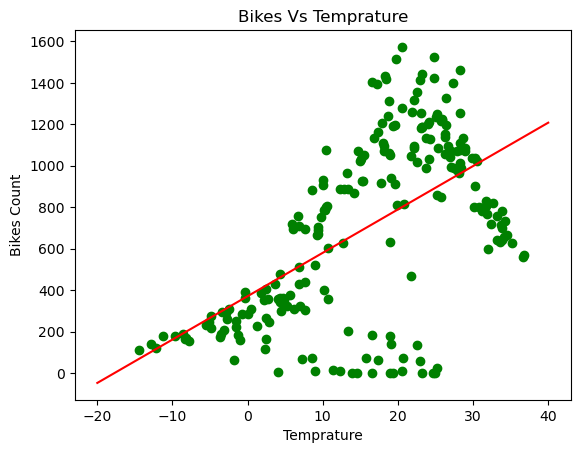

In [9]:
plt.scatter(x_train , y_train, label = 'Data' , color = 'green')
x = tf.linspace(-20,40,100) 
plt.plot(x,reg_model.predict(np.array(x).reshape(-1,1)), label = 'Fit' , color='red')
plt.title('Bikes Vs Temprature')
plt.xlabel('Temprature')        
plt.ylabel('Bikes Count')        

# Bike count vs All columns
## with Linear Regression model

In [10]:
train , valid , test = np.split(df.sample(frac = 1) , [int(0.6*len(df)), int(0.8*len(df))]) #splitting the data 
_, x_train_all , y_train_all = get_xy(train ,x=df.columns[1:], y = 'bike_count')
_, x_valid_all , y_valid_all = get_xy(valid ,x= df.columns[1:], y = 'bike_count')
_, x_test_all , y_test_all = get_xy(test ,x= df.columns[1:], y = 'bike_count')

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
reg_model_all = LinearRegression()
reg_model_all.fit(x_train_all, y_train_all)
print(f'Coffecient = {reg_model_all.coef_}, Interception = {reg_model_all.intercept_} \n R² ={reg_model_all.score(x_test_all,y_test_all)} ')

Coffecient = [[  0.           3.117197    -2.75012814  10.27553948 156.25947205
  -44.3002766  -39.08699155]], Interception = [453.3157855] 
 R² =0.5720427425662251 


## Neural network Model

In [12]:
normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis = None)
normalizer.adapt(x_train.reshape(-1))
nn_model = tf.keras.Sequential([
    normalizer
    ,tf.keras.layers.Dense(1)])      # First hidden layer with 128 neurons and ReLU activation
    

C:\Users\Reda\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
nn_model.compile(tf.keras.optimizers.Adam(learning_rate = 0.1),
              loss='mean_squared_error',
              )

In [14]:
history = nn_model.fit(x_train.reshape(-1), y_train, epochs=1000, validation_data=(x_valid, y_valid),verbose = 0)

In [90]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Text(0, 0.5, 'Bikes Count')

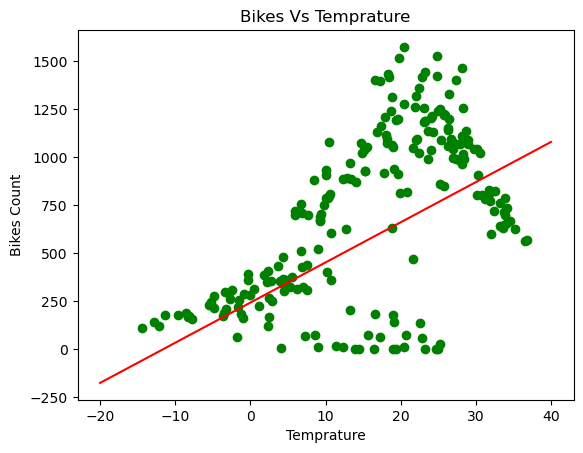

In [16]:
plt.scatter(x_train , y_train, label = 'Data' , color = 'green')
x = tf.linspace(-20,40,100) 
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)), label = 'Fit' , color='red')
plt.title('Bikes Vs Temprature')
plt.xlabel('Temprature')        
plt.ylabel('Bikes Count')        

In [85]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [88]:
history = nn_model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    verbose=0, epochs=100
)

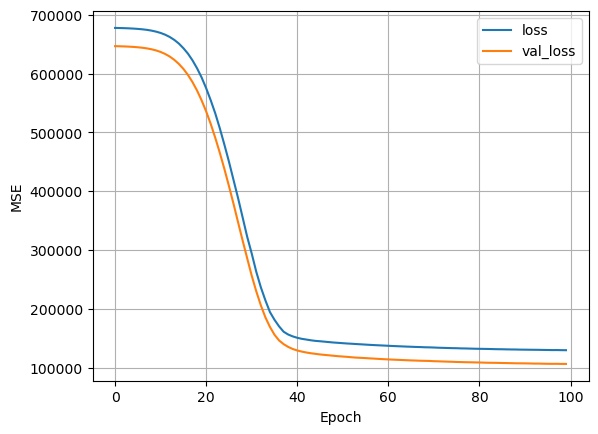

In [91]:
plot_loss(history)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


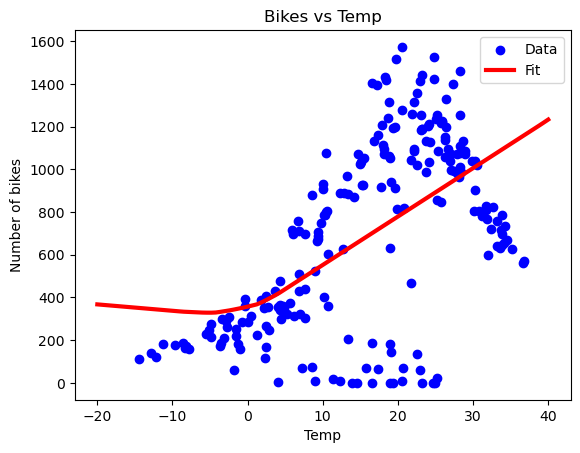

In [92]:
plt.scatter(x_train, y_train, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()     